# Exploring CIFAR-10, Transfer Learning and CNN model building

In this notebook our objective is to explore the famous CIFAR_10 and try to build models to accurately classify images.  
We will be trying out transfer learning techniques, namely VGG16 and ResNet50, and will also be building a customized CNN model.

Run the cell below to download or go to:
https://www.cs.toronto.edu/~kriz/cifar.html

In [ ]:
#(Optional) Download the data (163 MB)
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

## Table of contents
1. [Importing Libraries](#introduction)
2. [Importing and Preprocessing Data](#header1)
3. [VGG](#vgg)
4. [ResNet](#resnet)
5. [Custom CNN](#ccnn)
6. [Predictions](#pred)
7. [Wrongly classified images](#imagewrong)
8. [Conclusion](#con)

## Importing Libraries<a name="introduction"></a>

In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import tarfile
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
import os

In [2]:
from keras.preprocessing.image import ImageDataGenerator

In [3]:
import PIL
import PIL.Image

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


## Importing and Preprocessing Data<a name="header1"></a>

In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

!tar xzvf cifar-10-python.tar.gz

x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1


In [5]:
os.chdir('./cifar-10-batches-py')

In [6]:
os.listdir()

['batches.meta',
 'cifar_recog_cnn.h5',
 'cifar_recog_cnn_1.h5',
 'data_batch_1',
 'data_batch_2',
 'data_batch_3',
 'data_batch_4',
 'data_batch_5',
 'Model',
 'readme.html',
 'test_batch']

In [8]:
f=[]

In [9]:
for i in range(1,6):
    f.append(unpickle(f'data_batch_{i}'))

In [10]:
f_test = unpickle('test_batch')

In [11]:
lbl = unpickle('batches.meta')

label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

Now we will extract the labels into a useful format

In [12]:
y_label = {}
for x,i in enumerate(lbl[b'label_names']):
    print(f'Index {x}: {i}')
    y_label.update({x:i})

Index 0: b'airplane'
Index 1: b'automobile'
Index 2: b'bird'
Index 3: b'cat'
Index 4: b'deer'
Index 5: b'dog'
Index 6: b'frog'
Index 7: b'horse'
Index 8: b'ship'
Index 9: b'truck'


In [13]:
y_label

{0: b'airplane',
 1: b'automobile',
 2: b'bird',
 3: b'cat',
 4: b'deer',
 5: b'dog',
 6: b'frog',
 7: b'horse',
 8: b'ship',
 9: b'truck'}

In [14]:
print(f[0].keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


Retrieving X train and y train and processing them into the right format

In [15]:
X = []
y = []
for i in range(len(f)):
    X.extend(f[i][b'data'])
    y.extend(f[i][b'labels'])

In [16]:
X = np.array(X)
y = np.array(y)

The data is flattened so we will reshape them and merge the color channels:
- Index 0 - 1024 contains the *Red* channel
- Index 1024 - 2048 contains the *Green* channel
- Index 2048 - 3072 contains the *Blue* channel

**Note:** That the colors are merged in the BGR format for future transfer learning possibilities (VGG, ResNet, etc.).

In [17]:
X_data = []
for i in range(len(X)):
    r = X[i][0:1024].reshape(32,32)
    g = X[i][1024:2048].reshape(32,32)
    b = X[i][2048:3072].reshape(32,32)
    X_data.append(cv2.merge((b, g, r))) ##Merging Color channels in (BGR) format
X_data = np.array(X_data)

In [18]:
y = y.reshape(len(y),1)

Retrieving X test and y test and processing them into the right format

In [19]:
X_test_flat = np.array(f_test[b'data'])
y_test = np.array(f_test[b'labels'])

In [20]:
X_test = []
for i in range(len(X_test_flat)):
    r = X_test_flat[i][0:1024].reshape(32,32)
    g = X_test_flat[i][1024:2048].reshape(32,32)
    b = X_test_flat[i][2048:3072].reshape(32,32)
    X_test.append(cv2.merge((b, g, r)))
X_test = np.array(X_test)

In [21]:
y_test = y_test.reshape(len(y_test),1)

## Data Exploration

In [22]:
print('X_data Shape: ', X_data.shape)
print('y Shape: ', y.shape)

X_data Shape:  (50000, 32, 32, 3)
y Shape:  (50000, 1)


In [23]:
#Final Shapes
print('X_test Shape: ', X_test.shape)
print('y_test Shape: ', y_test.shape)

X_test Shape:  (10000, 32, 32, 3)
y_test Shape:  (10000, 1)


#### Let's take a look at the first 10 training images:  
We notice first the odd color of the images, this is expected because the color channels were merged in a B,G,R format for application in VGG and ResNet.

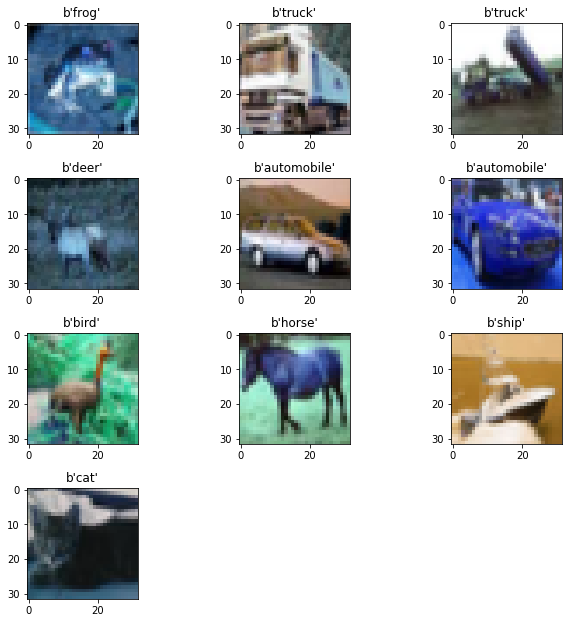

In [25]:
fig = plt.figure(figsize=(10,10))
for i in range(10):
    ax = plt.subplot(4,3,i+1)
    plt.imshow(X_data[i])
    plt.title(y_label[y[i][0]])
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

#### Let's take a look at the first 10 test images.

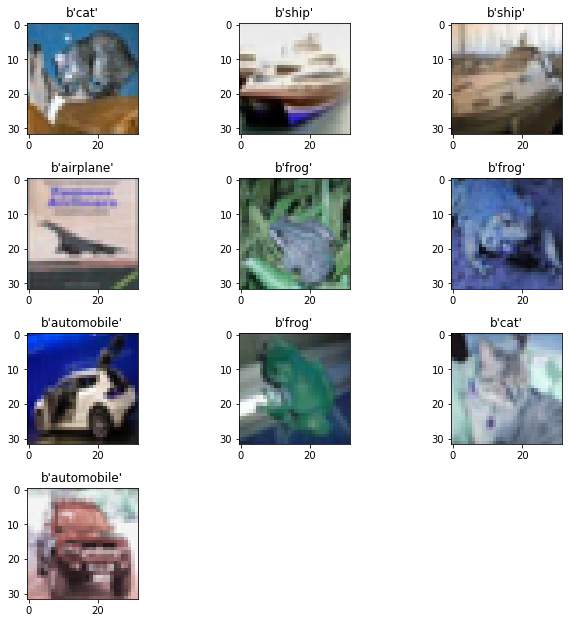

In [26]:
fig = plt.figure(figsize=(10,10))
for i in range(10):
    ax = plt.subplot(4,3,i+1)
    plt.imshow(X_test[i])
    plt.title(y_label[y_test[i][0]])
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

### OneHotEncoding the y values for classification.

In [25]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
y = onehotencoder.fit_transform(y.reshape(-1,1)).toarray()
y_test = onehotencoder.fit_transform(y_test.reshape(-1,1)).toarray()

In [26]:
X_data.shape

(50000, 32, 32, 3)

In [27]:
print("Shape of Images",X_data[0].shape)
print("Number of training examples:", len(X_data))

Shape of Images (32, 32, 3)
Number of training examples: 50000


In [28]:
print('y shape: ',y.shape)
print('y sample: ',y[0])

y shape:  (50000, 10)
y sample:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## VGG<a name="vgg"></a>

First we will try transfer learning with VGG16 with imagenet weights and adding a few Dense and Dropout layers

In [44]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(input_shape=[32,32,3], weights='imagenet', include_top=False)
for layers in vgg.layers:
    layers.trainable = False
x = tf.keras.layers.Flatten()(vgg.output)
x = tf.keras.layers.Dense(units=512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(units=256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
prediction = tf.keras.layers.Dense(units=10, activation='softmax')(x)
model = tf.keras.Model(inputs=vgg.input, outputs=prediction)

In [45]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [46]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [47]:
#Double checking input dimensions
print(X_data.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [48]:
model.fit(X_data, y, validation_data=(X_test,y_test), batch_size=256, epochs = 20)

Epoch 1/20
196/196 [==============================] - 13s 66ms/step - loss: 3.0364 - accuracy: 0.1708 - val_loss: 1.8532 - val_accuracy: 0.3377
Epoch 2/20
196/196 [==============================] - 13s 66ms/step - loss: 1.9067 - accuracy: 0.2860 - val_loss: 1.6260 - val_accuracy: 0.4415
Epoch 3/20
196/196 [==============================] - 13s 66ms/step - loss: 1.7092 - accuracy: 0.3729 - val_loss: 1.4637 - val_accuracy: 0.5002
Epoch 4/20
196/196 [==============================] - 13s 67ms/step - loss: 1.5872 - accuracy: 0.4304 - val_loss: 1.3849 - val_accuracy: 0.5488
Epoch 5/20
196/196 [==============================] - 13s 68ms/step - loss: 1.4892 - accuracy: 0.4794 - val_loss: 1.3315 - val_accuracy: 0.5679
Epoch 6/20
196/196 [==============================] - 13s 69ms/step - loss: 1.4164 - accuracy: 0.5095 - val_loss: 1.2714 - val_accuracy: 0.5882
Epoch 7/20
196/196 [==============================] - 15s 75ms/step - loss: 1.3561 - accuracy: 0.5392 - val_loss: 1.2468 - val_accuracy:

We get a validation accuracy of around 63% with the VGG network.  
  
Let us now plot the training curves and validation accuracy and loss.

#### Learning curves 

In [49]:
hist = model.history.history

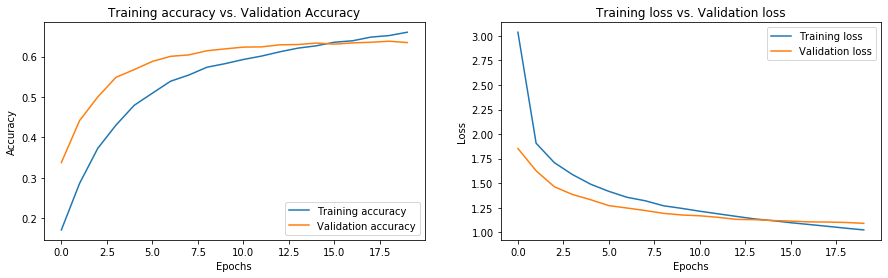

In [50]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(hist['accuracy'], label='Training accuracy')
plt.plot(hist['val_accuracy'], label='Validation accuracy')
plt.title('Training accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist['loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.title('Training loss vs. Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## ResNet50<a name="resnet"></a>

Secondly we will try transfer learning with ResNet50 with imagenet weights and adding a few Dense and Dropout layers.

In [55]:
from tensorflow.keras.applications.resnet50 import ResNet50
resnet = ResNet50(input_shape=[32,32,3], weights='imagenet', include_top=False)
for layers in resnet.layers:
    layers.trainable = False
x = tf.keras.layers.Flatten()(resnet.output)
x = tf.keras.layers.Dense(units=512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(units=256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
prediction = tf.keras.layers.Dense(units=10, activation='softmax')(x)
model1 = tf.keras.Model(inputs=resnet.input, outputs=prediction)

In [56]:
model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [57]:
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [58]:
model1.fit(X_data, y, validation_data=(X_test,y_test), batch_size=256, epochs = 15)

Epoch 1/15
196/196 [==============================] - 14s 59ms/step - loss: 1.9552 - accuracy: 0.2935 - val_loss: 1.4284 - val_accuracy: 0.5017
Epoch 2/15
196/196 [==============================] - 11s 58ms/step - loss: 1.5104 - accuracy: 0.4618 - val_loss: 1.2874 - val_accuracy: 0.5630
Epoch 3/15
196/196 [==============================] - 13s 64ms/step - loss: 1.3846 - accuracy: 0.5172 - val_loss: 1.2458 - val_accuracy: 0.5813
Epoch 4/15
196/196 [==============================] - 13s 66ms/step - loss: 1.3113 - accuracy: 0.5494 - val_loss: 1.1773 - val_accuracy: 0.5977
Epoch 5/15
196/196 [==============================] - 13s 66ms/step - loss: 1.2526 - accuracy: 0.5730 - val_loss: 1.1496 - val_accuracy: 0.6136
Epoch 6/15
196/196 [==============================] - 13s 65ms/step - loss: 1.2088 - accuracy: 0.5911 - val_loss: 1.1380 - val_accuracy: 0.6184
Epoch 7/15
196/196 [==============================] - 13s 65ms/step - loss: 1.1767 - accuracy: 0.5991 - val_loss: 1.1163 - val_accuracy:

We get a validation accuracy of around 63% with ResNet50.  
  
Let us now plot the training curves and validation accuracy and loss.

#### Learning Curves - ResNet50

In [59]:
hist1 = model1.history.history

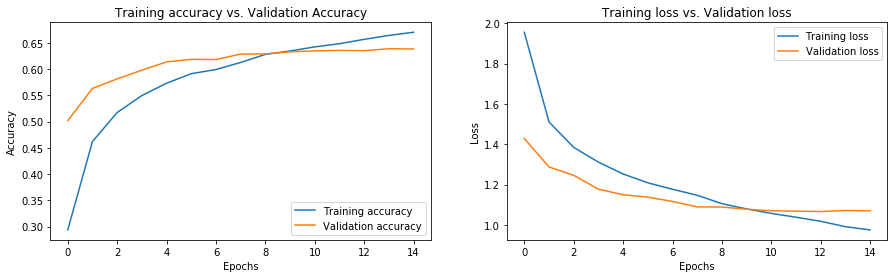

In [60]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(hist1['accuracy'], label='Training accuracy')
plt.plot(hist1['val_accuracy'], label='Validation accuracy')
plt.title('Training accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist1['loss'], label='Training loss')
plt.plot(hist1['val_loss'], label='Validation loss')
plt.title('Training loss vs. Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Custom CNN<a name="ccnn"></a>

Now we will implement a customized CNN model from scratch

In [56]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[32,32,3], padding='same'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.2))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.2))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.2))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(256, activation='relu'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Dropout(0.2))
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.2))
cnn.add(tf.keras.layers.Dense(units=64, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.2))
cnn.add(tf.keras.layers.Dense(units=10, activation='softmax'))

In [57]:
cnn.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
cnn.fit(X_data, y, validation_data=(X_test,y_test), batch_size=64,epochs = 50)

Epoch 1/50
782/782 [==============================] - 9s 10ms/step - loss: 1.7101 - accuracy: 0.3772 - val_loss: 1.6180 - val_accuracy: 0.4431
Epoch 2/50
782/782 [==============================] - 8s 10ms/step - loss: 1.3360 - accuracy: 0.5237 - val_loss: 1.1145 - val_accuracy: 0.5965
Epoch 3/50
782/782 [==============================] - 7s 9ms/step - loss: 1.1567 - accuracy: 0.5941 - val_loss: 1.7349 - val_accuracy: 0.4777
Epoch 4/50
782/782 [==============================] - 7s 10ms/step - loss: 1.0372 - accuracy: 0.6382 - val_loss: 1.2745 - val_accuracy: 0.5742
Epoch 5/50
782/782 [==============================] - 8s 10ms/step - loss: 0.9563 - accuracy: 0.6697 - val_loss: 0.8555 - val_accuracy: 0.7052
Epoch 6/50
782/782 [==============================] - 8s 10ms/step - loss: 0.8879 - accuracy: 0.6962 - val_loss: 0.7673 - val_accuracy: 0.7292
Epoch 7/50
782/782 [==============================] - 8s 10ms/step - loss: 0.8402 - accuracy: 0.7118 - val_loss: 1.0271 - val_accuracy: 0.6475


We are getting around 81% accuracy on the validation set!

We will save this model for future use

In [58]:
cnn.save('../model/cifar_recog_cnn_1.h5')

Let us now plot the training curves to understand the results better.

#### Learning Curves - Custom Model

In [49]:
hist2 = cnn.history.history

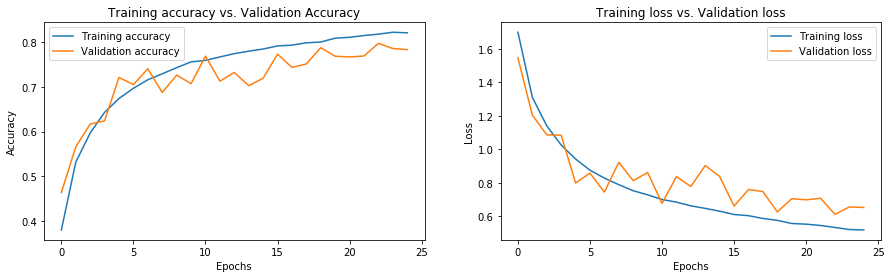

In [50]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(hist2['accuracy'], label='Training accuracy')
plt.plot(hist2['val_accuracy'], label='Validation accuracy')
plt.title('Training accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist2['loss'], label='Training loss')
plt.plot(hist2['val_loss'], label='Validation loss')
plt.title('Training loss vs. Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Predictions and Confusion Matrix<a name="pred"></a>

In [8]:
#Loading the saved model for inference
cnn1 = tf.keras.models.load_model('../model/cifar_recog_cnn_1.h5')

In [66]:
print('Prediction:', np.argmax(cnn1.predict(X_test[0].reshape(1,32,32,3))))
print('Actual:', np.where(y_test[0])[0][0])

Prediction: 3
Actual: 3


In [68]:
pred = cnn1.predict(X_test)
pred = np.argmax(pred,axis=1)
pred = pred.reshape(len(pred), 1)
pred.shape

(10000, 1)

In [69]:
y_test_fin = np.where(y_test)[1]
y_test_fin = y_test_fin.reshape(len(y_test_fin),1)
y_test_fin.shape

(10000, 1)

In [70]:
from sklearn.metrics import accuracy_score
accuracy_score(pred, y_test_fin)

0.8119

In [71]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(pred, y_test_fin)
cm

array([[878,  13,  55,  27,  17,  15,   5,  15,  63,  48],
       [  8, 915,   0,   2,   1,   2,   1,   0,   9,  53],
       [ 34,   6, 730,  81,  40,  42,  35,  22,   8,   8],
       [ 10,   3,  38, 638,  27, 136,  31,  34,  12,  22],
       [ 11,   2,  80,  54, 854,  60,  37,  54,   9,  12],
       [  2,   0,  34, 109,  19, 690,   8,  36,   3,   5],
       [ 15,  17,  43,  63,  16,  25, 881,   3,   6,   8],
       [  6,   0,  17,  18,  23,  28,   1, 831,   0,   9],
       [ 31,  12,   3,   6,   3,   0,   1,   2, 882,  15],
       [  5,  32,   0,   2,   0,   2,   0,   3,   8, 820]], dtype=int64)

<IPython.core.display.Javascript object>

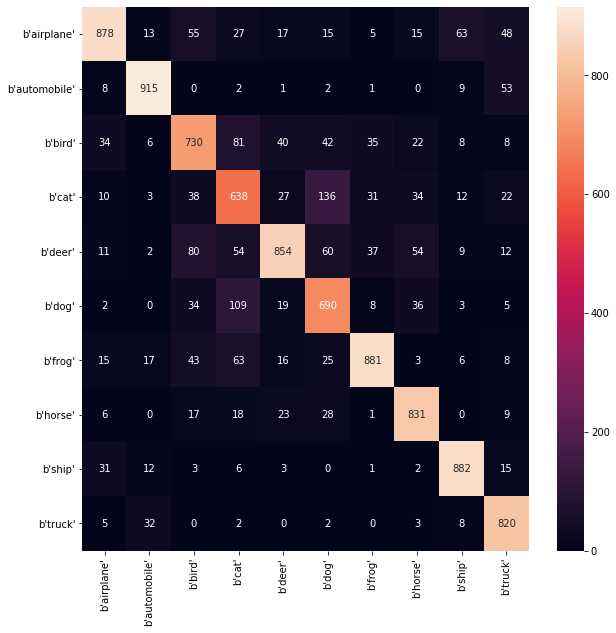

In [72]:
y_label_list = []
for i in range(10):
  y_label_list.append(y_label[i])
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot = True, xticklabels=y_label_list, yticklabels=y_label_list, fmt='g')

The model seems to often confuse:  
- A dog with a cat
- A deer with a bird
- A bird with a cat

## Plotting wrongly classified images<a name="imagewrong"></a>

Let's look at a few of the wrong predictions

In [183]:
compare_lst = pred==y_test_fin
wrong_pred_list = [x for x,i in enumerate(compare_lst) if i==False]
print('Total number of incorrect predictions:',len(wrong_pred_list))

Total number of incorrect predictions: 1881


In [184]:
#Adjust to see more or less number of images
num_eg = 50

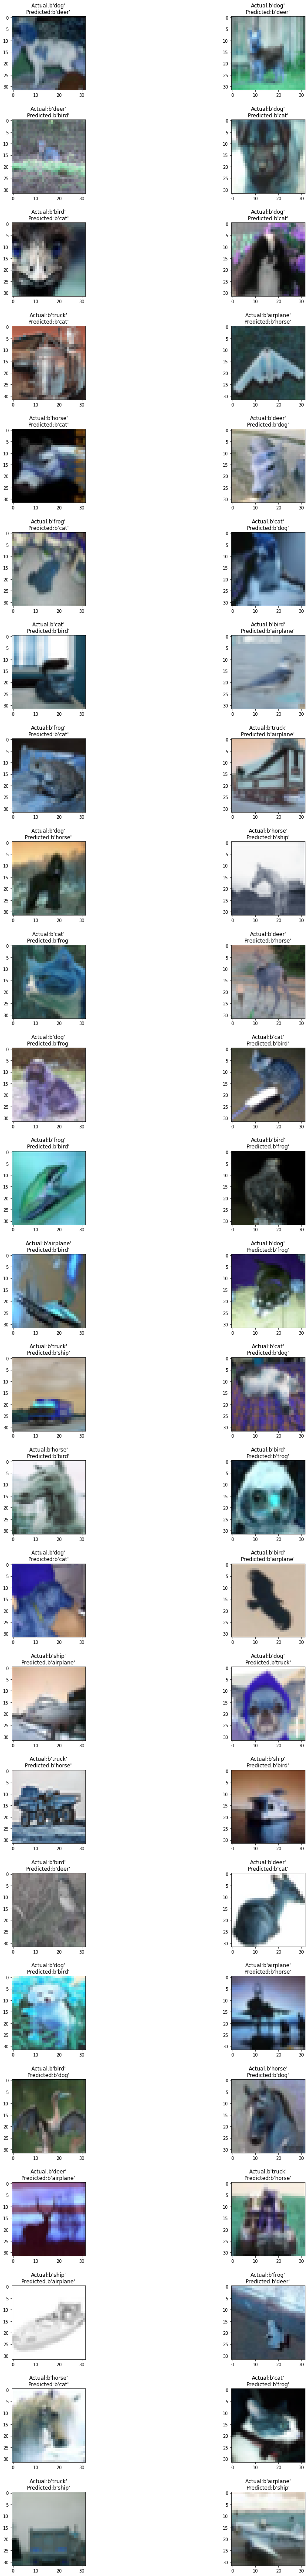

In [185]:
fig = plt.figure(figsize=(30,200))

for i in range(num_eg):
    ax = plt.subplot(num_eg-1/2,2,i+1)
    plt.imshow(X_test[wrong_pred_list[i+1]])
    plt.title(f'Actual:{y_label[y_test_fin[wrong_pred_list[i+1]][0]]}\nPredicted:{y_label[pred[wrong_pred_list[i+1]][0]]}')
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

## Conclusion<a name="con"></a>

In this notebook we have explored the CIFAR-10 Image dataset and have created models that predict the classes of the images.  
The CIFAR-10 dataset consists of 32x32 RGB images, with 50000 training examples and 10000 test examples.  

*The results of model training are as follows:*
- VGG: 
    - Training accuracy: 66%
    - Validation accuracy: 63%
    - Epochs: 20 (Converged accuracy)
- ResNet: 
    - Training accuracy: 67%
    - Validation accuracy: 63%
    - Epochs: 15 (Converged accuracy)
- Custom CNN: (Best)
    - Training accuracy: 86%
    - Validation accuracy: 81%
    - Epochs: 50 (Nearly converged)  
    
The Custom CNN model was saved as 'cifar_recog_cnn_1.h5'  

We observe that transfer learning works poorly with this dataset, this is most likely because the ImageNet weights we used. The average resolution of an ImageNet image is 469x387 in RGB which means the weights were trained on a lot higher quality data.  
- The average imagenet image *before crop* has: 469 x 387 x 3 = 5,44,509 activations  
- The imagenet image *after crop* has:  256 x 256 x 3 = 1,96,608 activations
  
  
- A single CIFAR-10 image has:  32 x 32 x 3 = 3,072 activations  

Which means that each CIFAR image provides around 1.5% of the data given by an average the imagenet image, thereby heavily restricting the accuracy the models could reach. We know that transfer learning shines when we have high quality but low volume data.

The custom CNN model was simple and was able to accurately classify images based to much higher degree namely 81%.  
From observing the confusion matrix we find that the model seems to most often confuse:
- A dog with a cat
- A deer with a bird
- A bird with a cat